In [4]:
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

X = np.load('data/X_train.npy')
y = np.genfromtxt('data/train_labels_new.csv', delimiter=' ', dtype=np.float32)
y_cl = np.argmax(y, axis=1)

ind_train = np.concatenate((np.where(y_cl == 0)[0][0:130], np.where(y_cl == 1)[0][:35], np.where(y_cl == 2)[0][:8], np.where(y_cl == 3)[0][:4]))
ind_test = list(set(range(0, 290)) - set(ind_train))

X_train = np.take(X, ind_train, axis=0)
y_train = np.take(y, ind_train, axis=0) # with y_cl maybe use no axis
X_test = np.take(X, ind_test, axis=0)
y_test = np.take(y, ind_test, axis=0)

def sampleIt(X, y):
    X_new = []; y_new = []; sample_w = []
    for i, row_y in enumerate(y):
        for cl, p_i in enumerate(row_y):
            X_new.append(X[i])
            y_new.append(cl)
            sample_w.append(p_i)
    return X_new, y_new, sample_w

X_train, y_train, w_train = sampleIt(X_train, y_train)
#X_test, y_test, w_test = sampleIt(X_test, y_test)

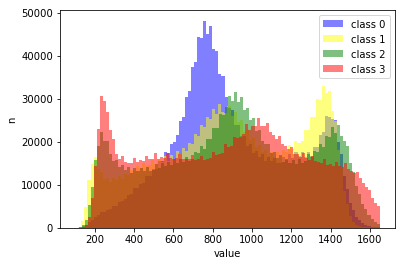

In [9]:
bins = [1, 282.10434686113894, 528.4350826042349, 635.7632261805744, 781.9301580581496, 962.0317275933281, 1079.2939329789033, 1246.3707282050862, 1393.0345691835053, 1721.8292294917992]
plt.hist(X[0][(X[0] > 100) & (X[0] < 1650) ], 100, facecolor='blue', alpha=0.5, label='class 0')
plt.hist(X[200][(X[200] > 100) & (X[200] < 1650) ], 100, facecolor='yellow', alpha=0.5, label='class 1')
plt.hist(X[276][(X[276] > 100) & (X[276] < 1650) ], 100, facecolor='green', alpha=0.5, label='class 2')
plt.hist(X[280][(X[280] > 100) & (X[280] < 1650) ], 100, facecolor='red', alpha=0.5, label='class 3')
plt.xlabel('value'); plt.ylabel('n'); plt.legend(); plt.show()
#plt.hist(y_cl, 4, facecolor='red', alpha=0.75)
#plt.xlabel('class'); plt.ylabel('n'); plt.show()

#from sklearn.metrics import accuracy_score
#f1_score([0, 1, 2], [0, 2, 1], average='micro')

In [46]:
from sklearn.base import BaseEstimator, TransformerMixin
import random
random.seed(99)

class SampleIt(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if y is None: return X
        

class RandomBinsExtraction(BaseEstimator, TransformerMixin):
    """Build n bins with mean from values"""
    def __init__(self, splits=610, hist_bins=None,
        images_x_from=None, images_x_to=None,
        images_y_from=None, images_y_to=None):

        self.splits = splits
        self.hist_bins = hist_bins

        self.images_x_from = images_x_from
        self.images_x_to = images_x_to
        self.images_y_from = images_y_from
        self.images_y_to = images_y_to
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_new = []
        if self.hist_bins is None:
            self.hist_bins = [[1, 349.57938688820047, 514.3746932858628, 669.4300432252885, 813.46816874832098, 950.71415810026383, 1094.3331288316649, 1245.2794633697374, 1390.4908175139283, 1700]]
            self.hist_bins = [[1, 298.8218117717887, 415.59953383322301, 529.00853569772312, 637.92188924633831, 741.69761514701986, 840.16357827183447, 936.05487410467663, 1034.8715039519698, 1139.5417907370197, 1246.5076326626559, 1350.2613661802782, 1451.0932380428474, 1700]]
            self.hist_bins = [[1, 333.43435360947996, 377.32086088315344, 561.2433820227202, 606.5170830782027, 698.9365593953033, 818.9350062989491, 944.6241279610327, 989.639268563091, 1111.174006398556, 1236.4177161776695, 1382.4980777213736, 1441.0342504446814, 1691.406521062321]]
            self.hist_bins = [[  1.00000000e+00,   3.18009334e+02,   4.62865448e+02,         5.15985085e+02,   6.30296831e+02,   7.79305680e+02,         8.66931009e+02,   9.76485681e+02,   1.01115385e+03,         1.16074931e+03,   1.27734759e+03,   1.32758847e+03,         1.42544073e+03,   1.74303213e+03]]

        first = True
        for row in X:
            row = row[600000:5700000]
            # This is feature selection 
            if self.images_x_from is not None and self.images_x_to is not None:
                images = np.split(row, 176)[self.images_x_from : self.images_x_to]
                
                # x needs to be set for this, but don't mind at the moment
                if self.images_y_from is not None and self.images_y_to is not None:
                    images_new = []
                    for image in images:
                        images_new.append(np.split(image, 208)[self.images_y_from : self.images_y_to])
                    images = np.array(images_new)

                row = np.array(images).flatten()
               
                
            splits = np.array_split(row, int(self.splits))
                
            features = []
            for j, split in enumerate(splits):
                i = int(j / len(splits) * len(self.hist_bins))
                
                features.append(np.histogram(split, bins=self.hist_bins[i])[0])

            #print(len(features))
            X_new.append(np.array(features).flatten())

        if first:
            #print("features: "+str(len(features)))
            first = False

        return X_new
    
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

pipe = Pipeline([
    ('BinsExtraction', RandomBinsExtraction(splits=1000)),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(C=1.0, solver='newton-cg', n_jobs=-1))
    #('logreg', GradientBoostingClassifier(n_estimators=300))
])

In [47]:
from sklearn.metrics import f1_score, log_loss
from scipy.stats import spearmanr
pipe.fit(X_train, y_train, **{'logreg__sample_weight': w_train}); print('fitted')
y_pr = pipe.predict_proba(X_test); #print(log_loss(y_test, y_pr))

corrs = []
for i in range(X_test.shape[0]):
    corrs.append(spearmanr(y_test[i], y_pr[i]).correlation)

meanrho = np.mean(corrs)
print(meanrho)
# 0.842 1000 score 0.823
# 0.846 5000
# 0.8495 1000 better bins

fitted
0.849557522124


In [18]:
import random
def run(a):
    pipe = Pipeline([
        ('BinsExtraction', RandomBinsExtraction(splits=1000, hist_bins=a)),
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(C=1.0, solver='newton-cg', n_jobs=2))
        #('linearSVC', LinearSVC(C=1.0, max_iter=1000))
    ])
    pipe.fit(X_train, y_train, **{'logreg__sample_weight': w_train});
    y_pr = pipe.predict_proba(X_test);

    corrs = []
    for i in range(X_test.shape[0]):
        corrs.append(spearmanr(y_test[i], y_pr[i]).correlation)

    meanrho = np.mean(corrs)
    print("\x1b[1;31m%s\x1b[0m \t%s" % (meanrho, a))
    
hist_bins = [[1, 298.8218117717887, 415.59953383322301, 529.00853569772312, 637.92188924633831, 741.69761514701986, 840.16357827183447, 936.05487410467663, 1034.8715039519698, 1139.5417907370197, 1246.5076326626559, 1350.2613661802782, 1451.0932380428474, 1700]]
for i in range(100):
    bins_new = []
    for b1 in hist_bins:
        bins_new2 = [1]
        for b2 in b1[1:]:
            bins_new2.append(random.uniform(b2 - 50, b2 + 50))
        bins_new.append(np.sort(bins_new2))
    run(bins_new)
    
for i in range(100):
    bins_new = []
    for b1 in [hist_bins[0], hist_bins[0]]:
        bins_new2 = [1]
        for b2 in b1[1:]:
            bins_new2.append(random.uniform(b2 - 50, b2 + 50))
        bins_new.append(np.sort(bins_new2))
    run(bins_new)
    
for i in range(100):
    bins_new = []
    for b1 in [hist_bins[0], hist_bins[0]]:
        bins_new2 = [1]
        for b2 in b1[1:]:
            bins_new2.append(random.uniform(b2 - 100, b2 + 100))
        bins_new.append(np.sort(bins_new2))
    run(bins_new)
    
for i in range(100):
    bins_new = []
    for b1 in [hist_bins[0], hist_bins[0], hist_bins[0]]:
        bins_new2 = [1]
        for b2 in b1[1:]:
            bins_new2.append(random.uniform(b2 - 50, b2 + 50))
        bins_new.append(np.sort(bins_new2))
    run(bins_new)

0.847787610619 	[array([  1.00000000e+00,   3.35449400e+02,   3.88723194e+02,
         5.65059077e+02,   6.22475526e+02,   7.31687677e+02,
         8.01396794e+02,   9.39229718e+02,   9.85000750e+02,
         1.12059527e+03,   1.26373768e+03,   1.37501585e+03,
         1.41782920e+03,   1.72848716e+03])]
0.846017699115 	[array([  1.00000000e+00,   2.93233495e+02,   3.86129190e+02,
         5.53866229e+02,   6.61814437e+02,   7.38500063e+02,
         8.43266684e+02,   9.48035252e+02,   1.04804102e+03,
         1.16604595e+03,   1.27340126e+03,   1.32028983e+03,
         1.40315501e+03,   1.66051515e+03])]
0.840707964602 	[array([  1.00000000e+00,   2.79571920e+02,   4.23650632e+02,
         5.75122327e+02,   6.29599184e+02,   7.28620262e+02,
         8.45886451e+02,   9.80886157e+02,   1.04367264e+03,
         1.11905904e+03,   1.27217397e+03,   1.39944346e+03,
         1.48045517e+03,   1.68984465e+03])]
0.847787610619 	[array([  1.00000000e+00,   2.66047105e+02,   4.11681763e+02,
    

0.846017699115 	[array([  1.00000000e+00,   2.76234472e+02,   3.77963605e+02,
         5.53864728e+02,   6.70762357e+02,   7.16778873e+02,
         8.29279289e+02,   9.74897271e+02,   1.04464490e+03,
         1.11129242e+03,   1.29618858e+03,   1.37722309e+03,
         1.43175643e+03,   1.69478768e+03])]
0.846017699115 	[array([  1.00000000e+00,   2.98832271e+02,   4.29051378e+02,
         5.24953244e+02,   6.02823575e+02,   7.24609468e+02,
         8.03038727e+02,   9.36304040e+02,   1.04623679e+03,
         1.14972881e+03,   1.20356484e+03,   1.35583991e+03,
         1.47922879e+03,   1.70729118e+03])]
0.846017699115 	[array([  1.00000000e+00,   2.82597762e+02,   4.44140086e+02,
         5.18963514e+02,   6.67265029e+02,   6.92752000e+02,
         7.99005892e+02,   9.31844772e+02,   9.93237414e+02,
         1.10905205e+03,   1.28982953e+03,   1.37792977e+03,
         1.43096513e+03,   1.66145323e+03])]
0.847787610619 	[array([  1.00000000e+00,   3.21961366e+02,   4.36406927e+02,
    

0.838938053097 	[array([  1.00000000e+00,   2.57839895e+02,   3.76408337e+02,
         5.72459369e+02,   6.83123992e+02,   7.62871039e+02,
         8.82529084e+02,   9.55054820e+02,   1.07750463e+03,
         1.08989508e+03,   1.23377471e+03,   1.33679972e+03,
         1.43500230e+03,   1.67695842e+03])]
0.846017699115 	[array([  1.00000000e+00,   2.80812402e+02,   4.39970405e+02,
         5.73944819e+02,   6.80128537e+02,   7.30708779e+02,
         8.50468245e+02,   9.09132863e+02,   1.01574309e+03,
         1.18069323e+03,   1.25035966e+03,   1.30904095e+03,
         1.44927322e+03,   1.72890080e+03])]
0.846017699115 	[array([  1.00000000e+00,   3.16907098e+02,   3.76745033e+02,
         5.17884884e+02,   6.20007776e+02,   7.13784520e+02,
         8.14723211e+02,   9.69829527e+02,   1.04020270e+03,
         1.16984188e+03,   1.23616813e+03,   1.38446669e+03,
         1.40181693e+03,   1.68411597e+03])]
0.840707964602 	[array([  1.00000000e+00,   2.67888614e+02,   3.92456600e+02,
    

0.842477876106 	[array([  1.00000000e+00,   2.77607762e+02,   4.28976254e+02,
         5.11863724e+02,   6.07242261e+02,   7.18621687e+02,
         8.38102078e+02,   9.44049005e+02,   1.05790436e+03,
         1.09293253e+03,   1.25629941e+03,   1.30898953e+03,
         1.45410106e+03,   1.67166196e+03])]
0.842477876106 	[array([  1.00000000e+00,   3.20378874e+02,   4.13116625e+02,
         4.90736216e+02,   6.37930271e+02,   7.36881086e+02,
         8.61373973e+02,   9.76003337e+02,   1.08475363e+03,
         1.18651478e+03,   1.20235425e+03,   1.35309597e+03,
         1.44033673e+03,   1.73148354e+03])]
0.840707964602 	[array([  1.00000000e+00,   2.74222794e+02,   4.57311266e+02,
         4.92649123e+02,   6.02204168e+02,   7.17439805e+02,
         8.24891893e+02,   9.66881423e+02,   1.02310472e+03,
         1.14618310e+03,   1.28202418e+03,   1.30988793e+03,
         1.45105702e+03,   1.71372573e+03])]
0.842477876106 	[array([  1.00000000e+00,   3.20959340e+02,   3.70869527e+02,
    

0.846017699115 	[array([  1.00000000e+00,   2.71606353e+02,   4.49464247e+02,
         5.02853664e+02,   6.27278627e+02,   7.52712859e+02,
         8.82592380e+02,   9.76691650e+02,   1.02678549e+03,
         1.14001733e+03,   1.24895254e+03,   1.33098387e+03,
         1.47134290e+03,   1.65408137e+03]), array([  1.00000000e+00,   3.14232374e+02,   3.69029109e+02,
         5.10820997e+02,   6.19626550e+02,   7.68477895e+02,
         8.10794068e+02,   9.26867303e+02,   1.03052309e+03,
         1.09504811e+03,   1.26139151e+03,   1.31860081e+03,
         1.41051711e+03,   1.74644864e+03])]
0.846017699115 	[array([  1.00000000e+00,   3.41524900e+02,   4.14130843e+02,
         5.03383988e+02,   6.31097947e+02,   7.41858968e+02,
         8.69313558e+02,   9.09834883e+02,   9.99959573e+02,
         1.18012523e+03,   1.28355180e+03,   1.37936385e+03,
         1.47001005e+03,   1.69895585e+03]), array([  1.00000000e+00,   3.26958519e+02,   4.53246657e+02,
         5.66144194e+02,   5.97610248e

0.844247787611 	[array([  1.00000000e+00,   2.99903868e+02,   3.89007216e+02,
         5.08808498e+02,   6.83257158e+02,   7.88874080e+02,
         8.62111117e+02,   9.03214571e+02,   1.00817856e+03,
         1.16463123e+03,   1.24928991e+03,   1.34699494e+03,
         1.43296870e+03,   1.74383349e+03]), array([  1.00000000e+00,   2.73694430e+02,   4.05830826e+02,
         4.89528989e+02,   6.79118912e+02,   7.58937758e+02,
         8.06223916e+02,   9.64781120e+02,   1.07975042e+03,
         1.13544807e+03,   1.26531208e+03,   1.35490338e+03,
         1.48071213e+03,   1.74162201e+03])]
0.838938053097 	[array([  1.00000000e+00,   2.52393019e+02,   3.86341251e+02,
         4.88223104e+02,   6.02075034e+02,   7.03327729e+02,
         8.49610170e+02,   8.98915508e+02,   1.07947611e+03,
         1.11981574e+03,   1.25849606e+03,   1.30545318e+03,
         1.45687622e+03,   1.68281093e+03]), array([  1.00000000e+00,   3.45442579e+02,   4.30857427e+02,
         5.44247751e+02,   6.02820588e

0.842477876106 	[array([  1.00000000e+00,   3.01520920e+02,   4.38779384e+02,
         5.72678434e+02,   6.33629425e+02,   7.02907043e+02,
         8.88694095e+02,   9.39399814e+02,   9.89227232e+02,
         1.13905316e+03,   1.26738880e+03,   1.36881704e+03,
         1.44133026e+03,   1.65414177e+03]), array([  1.00000000e+00,   3.06273540e+02,   3.77815942e+02,
         5.04327371e+02,   6.75767279e+02,   7.77346154e+02,
         8.77980770e+02,   9.21294180e+02,   1.06934432e+03,
         1.12812496e+03,   1.24987884e+03,   1.36341088e+03,
         1.43203686e+03,   1.67473255e+03])]
0.838938053097 	[array([  1.00000000e+00,   3.28953916e+02,   4.44081127e+02,
         5.10669930e+02,   6.16336199e+02,   7.90532738e+02,
         8.34749138e+02,   9.68551614e+02,   1.02250147e+03,
         1.12285161e+03,   1.21367774e+03,   1.39423085e+03,
         1.47829422e+03,   1.68849847e+03]), array([  1.00000000e+00,   3.07738989e+02,   3.69816223e+02,
         5.17867780e+02,   6.29220167e

KeyboardInterrupt: 

In [233]:
# Not random so far
ind_train = np.concatenate((np.where(y_cl == 0)[0][0:120], np.where(y_cl == 1)[0][:30], np.where(y_cl == 2)[0][:7], np.where(y_cl == 3)[0][:4]))
ind_test = list(set(range(0, 290)) - set(ind_train))
print(y_cl[ind_train])
print(y_cl[ind_test])
#ind_train

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 2 2 2 2 3 3 3 3]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 3 3 3]


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.69827846572032615

In [206]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=13, n_jobs=-1, random_state=99)

ind = np.concatenate((np.where(y_cl == 0)[0][0:3], np.where(y_cl == 1)[0][:3], np.where(y_cl == 2)[0][:3], np.where(y_cl == 3)[0][:3]))
samples = np.take(X, ind, axis=0)
centers = []
for i, sample in enumerate(samples):
    # sample = sample[1672390 : -786303]

    sample = sample[(sample > 0) & (sample < 1800)]
    kmeans.fit(np.array([sample]).T)
    centers.append(np.sort(np.array(kmeans.cluster_centers_).flatten()))
    print(str(i+1) + ' / ' + str(len(samples)))

if False: # use all centers
    values = np.array(centers).flatten()
    values = np.sort(values)
else: # take means of centers
    values = np.mean(centers, axis=0)

edges = [1] # leave out 0
for center_1, center_2 in zip(values[:-1], values[1:]):
    edges.append(.5 * (center_1 + center_2))
edges.append(1700)
"""
[1, 349.57938688820047, 514.3746932858628, 669.4300432252885, 813.46816874832098, 950.71415810026383, 1094.3331288316649, 1245.2794633697374, 1390.4908175139283, 1700]
[1, 298.8218117717887, 415.59953383322301, 529.00853569772312, 637.92188924633831, 741.69761514701986, 840.16357827183447, 936.05487410467663, 1034.8715039519698, 1139.5417907370197, 1246.5076326626559, 1350.2613661802782, 1451.0932380428474, 1700]
"""
edges

0 done
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done


[1,
 298.8218117717887,
 415.59953383322301,
 529.00853569772312,
 637.92188924633831,
 741.69761514701986,
 840.16357827183447,
 936.05487410467663,
 1034.8715039519698,
 1139.5417907370197,
 1246.5076326626559,
 1350.2613661802782,
 1451.0932380428474]